
<h9><center></center></h9>

<h1>
<hr style=" border:bold; height:10px;">
<center>Machine Learning for Network Science -  Kaggle Challenge</center>
<hr style=" border:none; height:3px;">
</h1>

Challenge based on [Kaggle](https://www.kaggle.com/c/mlns-2021) competition.

#**Import on COLAB**#

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle
from google.colab import files
# Here you should upload your Kaggle API key (see : https://www.kaggle.com/docs/api (Authentification paragraph))
files.upload()
# Kaggle API identification
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
# Download the entire dataset in zip format
! kaggle competitions download -c MLNS-2021-2
# Unzip file
! unzip /content/MLNS-2021-2.zip
!pip install "tqdm==4.43.0"

     |████████████████████████████████| 61kB 3.2MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=00860f32c051d5586e786234f2d1049d71632d992b75b5ef1d4f4ae841cfaf82
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


Saving kaggle.json to kaggle.json
ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              222KB  2021-04-05 06:19:09           1964        205  1.0              
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44           1206        129  1.0              
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27            926         96  1.0              
imsparsh/musicnet-dataset                               

#**Import DATA**#

In [3]:

from tqdm.contrib.concurrent import process_map
import csv
import numpy as np
import pandas as pd

import os
import networkx as nx
import random
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import preprocessing
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch.utils.data import TensorDataset, DataLoader
from copy import deepcopy
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.metrics import roc_curve ,roc_auc_score
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore")

In [148]:
#Loading DATA from Txt files
path = './'

with open(os.path.join(os.path.dirname(path),   'testing_set.txt'), "r") as f:
    reader = csv.reader(f)
    testing_set = list(reader)
with open(os.path.join(os.path.dirname(path),   'training_set.txt'), "r") as f:
    reader = csv.reader(f)
    training_set = list(reader)
with open(os.path.join(os.path.dirname(path),  'node_information.csv'), "r") as f:
            reader = csv.reader(f)
            node_info = list(reader)
training_set = [element[0].split(" ") for element in training_set]
testing_set = [element[0].split(" ") for element in testing_set]
Train_ratio = 1
to_keep = random.sample(range(len(training_set)), k=int(round(len(training_set)*Train_ratio)))
training_set_reduced = [training_set[i] for i in to_keep]
IDs = [element[0] for element in node_info]
corpus = [element[5] for element in node_info]

node_info = pd.DataFrame(node_info ,columns= ['ID' , 'year' ,'titles','authors' , 'journals' , 'corpus']).set_index('ID')
Train_DF = pd.DataFrame({'Source':[int(element[0]) for element in training_set_reduced], 
                     'Target':[int(element[1]) for element in training_set_reduced],
                    'Ind' : [int(element[2]) for element in training_set_reduced]})
#Creating Graph from DATA
G = nx.from_pandas_edgelist(Train_DF[Train_DF.Ind == 1], "Source", "Target", create_using=nx.DiGraph())

nodes_manquant = [int(node) for node in IDs if int(node) not in G.nodes()]

G.add_nodes_from(nodes_manquant)

#Verify if all nodes are in the graph
assert len(G.nodes()) == len(IDs)

In [150]:
tuple_train = [(int(element[0]),int(element[1])) for element in training_set_reduced ]
label_train = [int(element[2]) for element in training_set_reduced]
print('tuple to train : ', len(tuple_train))
all_tuples = [tuple(elt[:2]) for elt in np.array(training_set).astype(int)] +\
            [tuple(elt[:2]) for elt in np.array(testing_set).astype(int)]

tuple to train :  615512


#Features extractions 

##Features related to papers informations

In [151]:
"inspired from tutorial on https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5"
## Load Doc2VEC models
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]


In [152]:
max_epochs = 50
alpha = 0.025
model = Doc2Vec(alpha=alpha,min_alpha=0.00025
                , vector_size=128, window=2, min_count=1, workers=4 , dm = 1)                  
model.build_vocab(documents)
for epoch in tqdm(range(max_epochs)):
    
    model.train(documents,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

Corpus_embedding = {} 
for source in tqdm(list(node_info.index.values)) :
    Corpus_embedding[int(source)] = model.infer_vector(node_info.loc[source].corpus).reshape(1,-1)

In [153]:
#Load doc2vec_similarity into dictionnary
doc2vec_similarity = {} 
for elt in tqdm(all_tuples) :
    doc2vec_similarity[elt] = cosine_similarity(Corpus_embedding[elt[0]], Corpus_embedding[elt[1]])

In [154]:
#TF-IDF for Corpus, titles, authors
vectorizer_corpus = TfidfVectorizer(stop_words="english")
features_TFIDF_corpus = vectorizer_corpus.fit_transform(corpus)


def papers_features( pairs ) : 
    papers_feature = []
    source = pairs[0]
    target = pairs[1]
    source_info = node_info.loc[str(source)]
    target_info = node_info.loc[str(target)]
    source_corpus = set(source_info.corpus)
    target_corpus = set(target_info.corpus)
    source_auth = set(source_info.authors)
    target_auth = set(target_info.authors) 
    source_titles = set(source_info.titles)
    target_titles  = set(target_info.titles)  
    diff_year = int(source_info.year) - int(target_info.year)
    overlap_words = len(source_corpus.intersection(target_corpus))
    overlap_auths = len(source_auth.intersection(target_auth))
    overlap_titles = len(source_titles.intersection(target_titles))
    cosine_sim_TFIDF_corpus = cosine_similarity(features_TFIDF_corpus[IDs.index(str(source))],
                        features_TFIDF_corpus[IDs.index(str(target))])
   
    papers_feature.append(overlap_words)
    papers_feature.append(diff_year)
    papers_feature.append(overlap_auths)
    papers_feature.append(overlap_titles)
    papers_feature.append(cosine_sim_TFIDF_corpus.item())
   
    papers_feature.append(doc2vec_similarity[pairs].item())  
    return np.vstack(papers_feature)


In [155]:
if __name__ == '__main__':
    train_tr_papers = process_map(papers_features, tqdm(tuple_train), max_workers=6)

In [156]:
Features_papers = ['overlap_words','diff_year','overlap_auths','overlap_titles'
,'cosine_sim_TFIDF_corpus','doc2vec_similarity']

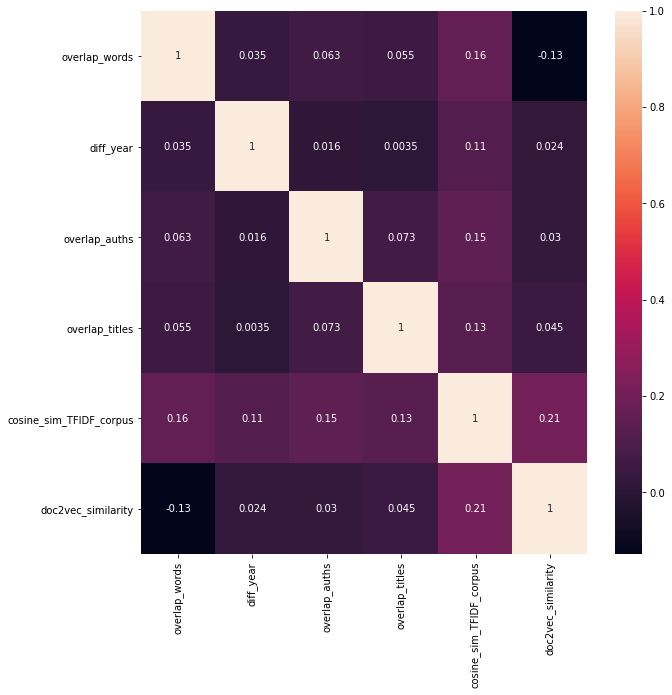

In [157]:
df = pd.DataFrame(np.array(train_tr_papers).squeeze(), columns= Features_papers)
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr() , annot=True);

##Features related to graph

In [158]:

import math
def common_neighbors(G, S_T):
    S = S_T[0]
    T = S_T[1]
    if str(S) in nodes_manquant :
        S = str(S)
    if str(T) in nodes_manquant :
        T = str(T)
    common_neighbors =  set(set(nx.neighbors(G , S)).intersection(set(nx.neighbors(G ,  T))))
    return common_neighbors
#Create Undirected Graph for Jaccard
Und_G = nx.Graph(G)
# Load common_neighbors and Jaccard coef. into dictionnary
common_neighbors_dico = {}
for elt in tqdm(all_tuples) :
    common_neighbors_dico[elt] = common_neighbors(G, elt)
"-------------------------------------------"
def AdamicAdar(G, S_T):
    return sum(1 / math.log(G.degree(w)) for w in common_neighbors_dico[S_T])

def resource_allocation_index(G, S_T):
    return sum(1 / G.degree(w) for w in common_neighbors_dico[S_T])
## Loading of Dicos
AAI_dico = {}
for elt in tqdm(all_tuples) :
    AAI_dico[elt] =  AdamicAdar(G, elt)
resource_allocation_dico = {}
for elt in tqdm(all_tuples) :
    resource_allocation_dico[elt] =  resource_allocation_index(G, elt )
Jaccard_dico = {}
for elt in tqdm(all_tuples) :
    Jaccard_dico[elt] =  list(nx.jaccard_coefficient(Und_G , [(elt[0],elt[1])]))[0][2]

out_degree_centrality =  nx.out_degree_centrality(G)
in_degree_centrality = nx.in_degree_centrality(G)
page_rank = nx.pagerank_scipy(G)
hub_score, authority_score = nx.hits(G )


In [159]:

def get_graph_feature(pairs, G=G , Und_G = Und_G) :
    feat = []
    source = pairs[0]
    target = pairs[1]
    feat.append(out_degree_centrality[source])
    feat.append(in_degree_centrality[target])
    feat.append(page_rank[target])
    feat.append(out_degree_centrality[source] * in_degree_centrality[target])
    feat.append(hub_score[source])
    feat.append(authority_score[target])
    feat.append(len(common_neighbors_dico[(source,target)]))
    feat.append(AAI_dico[(source,target)])
    feat.append(resource_allocation_dico[(source,target)])
    feat.append(Jaccard_dico[(source,target)])
    # try :
    #     Graph.remove_edge(source, target)
    #     try : 
    #         shortest_path = nx.shortest_path_length(Graph, source, target)
    #         Graph.add_edge(source, target)
    #     except :
    #         shortest_path = 1000
    #         Graph.add_edge(source, target)
    # except :
    #     try : 
    #         shortest_path = nx.shortest_path_length(Graph, source, target)
    #     except :
    #         shortest_path = 1000
    # feat.append(shortest_path)

    return np.vstack(feat)

In [160]:
if __name__ == '__main__':
    train_tr_graphs = process_map(get_graph_feature, tqdm(tuple_train), max_workers=6)

In [161]:
Features_graph = ['out_degree_centrality','in_degree_centrality','page_rank','preferential_attach','hub_score','authority_score','common_neighbors'
,'AdamicAdar', 'resource_allocation' , 'Jaccard']

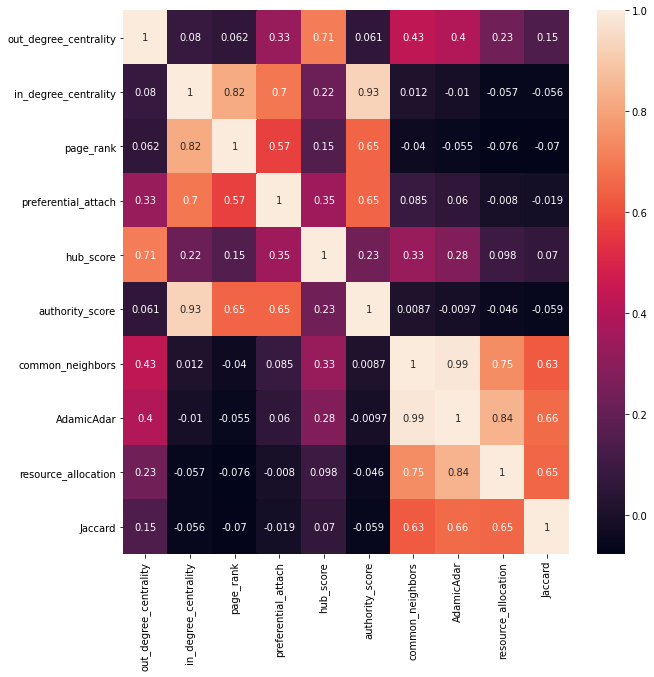

In [162]:
df = pd.DataFrame(np.array(train_tr_graphs).squeeze(), columns= Features_graph)
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr() , annot=True);

#Training

In [163]:
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , f1_score
scaler = StandardScaler()
train = np.hstack((np.array(train_tr_graphs).squeeze(),np.array(train_tr_papers).squeeze()))
train =  scaler.fit_transform(train.squeeze())
X_train, X_val, y_train, y_val = train_test_split(     train, label_train, test_size=0.1, random_state=42)


## Logistic Regression

In [164]:

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print('---------------------------------------------------------')
print('Train Score')
print(classification_report(y_train , clf.predict(X_train)))
print('---------------------------------------------------------')
print('Valid Score')
print(classification_report(y_val , clf.predict(X_val)))

---------------------------------------------------------
Train Score
              precision    recall  f1-score   support

           0       0.94      0.98      0.96    252469
           1       0.98      0.95      0.96    301491

    accuracy                           0.96    553960
   macro avg       0.96      0.96      0.96    553960
weighted avg       0.96      0.96      0.96    553960

---------------------------------------------------------
Valid Score
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     27913
           1       0.98      0.95      0.96     33639

    accuracy                           0.96     61552
   macro avg       0.96      0.96      0.96     61552
weighted avg       0.96      0.96      0.96     61552



In [165]:
X = pd.DataFrame(np.array(X_train).squeeze(), columns= Features_graph+Features_papers)
from sklearn.feature_selection import RFE
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=5, step=10, verbose=5)
rfe_selector.fit(X_train, y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(rfe_feature, 'selected features')

Fitting estimator with 16 features.
Fitting estimator with 6 features.
['in_degree_centrality', 'preferential_attach', 'common_neighbors', 'AdamicAdar', 'Jaccard'] selected features


##Ensemble methode : Gradient Boosting

In [166]:
classifier = lgb.LGBMClassifier(objective='binary', reg_lambda=10, n_estimators=20000)


# trainTraining_data
classifier.fit(X_train, y_train,
                   eval_set=[(X_val, y_val)],
                    early_stopping_rounds=10, verbose=False)
print('---------------------------------------------------------')
print('Train Score')
print(classification_report(y_train , classifier.predict(X_train)))
print('---------------------------------------------------------')
print('Valid Score')
print(classification_report(y_val , classifier.predict(X_val)))

---------------------------------------------------------
Train Score
              precision    recall  f1-score   support

           0       0.97      0.98      0.98    252469
           1       0.99      0.98      0.98    301491

    accuracy                           0.98    553960
   macro avg       0.98      0.98      0.98    553960
weighted avg       0.98      0.98      0.98    553960

---------------------------------------------------------
Valid Score
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     27913
           1       0.98      0.97      0.98     33639

    accuracy                           0.98     61552
   macro avg       0.98      0.98      0.98     61552
weighted avg       0.98      0.98      0.98     61552



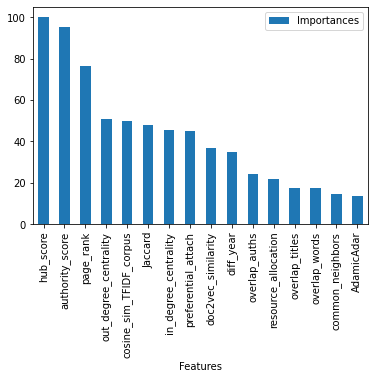

In [167]:
feature_importance = pd.DataFrame(classifier.feature_importances_)
feature_importance = 100.0 * \
    (feature_importance / feature_importance.max())
feature_importance = pd.concat([pd.DataFrame(Features_graph+Features_papers),feature_importance], axis=1, ignore_index=True)
feature_importance.columns = ['Features', 'Importances']
feature_importance = feature_importance.sort_values(
    by='Importances', axis=0, ascending=False)
ax = feature_importance.plot.bar(x='Features', y='Importances', rot=90)

In [168]:
f1_score(classifier.predict(X_val) , y_val)

0.9785182199531252

In [169]:
tuple_test = [(int(element[0]),int(element[1])) for element in testing_set ]

if __name__ == '__main__':
    test_tr_papers = process_map(papers_features, tqdm(tuple_test), max_workers=4)
if __name__ == '__main__':
    test_tr_graphs = process_map(get_graph_feature, tqdm(tuple_test), max_workers=4)


In [170]:
test = np.hstack((np.array(test_tr_graphs)[:,0:10].squeeze(),np.array(test_tr_papers).squeeze()))
test =  scaler.transform(test.squeeze())
predictions = list(classifier.predict(test))
print(np.sum(predictions))
# write predictions to .csv file suitable for Kaggle (just make sure to add the column names)
predictions = zip(range(len(testing_set)), predictions)
rows =[]
for row in predictions:
       rows.append(row) 

np.savetxt("file_name.csv", rows, delimiter=",", fmt='%s')

16997


## MLP Classifier

In [171]:

#Define a MLP classifier

class MLP_feat(nn.Module):
    
    def __init__(self):
        super(MLP_feat, self).__init__()
        self.linear1 = nn.Linear(16,256)
        self.linear2 = nn.Linear(256,256)
        self.linear3 = nn.Linear(256,1)
        self.act = nn.Sigmoid()
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()

    def forward(self, x  ):
        
                
        out = self.linear1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.linear2(out)       
        out = self.relu(out)
        out = self.dropout(out)
        out = self.linear3(out)
        out = self.act(out)
      
        return out

mlp_feat = MLP_feat().cuda()

In [172]:

train_set, val_set = TensorDataset(torch.Tensor(X_train),torch.Tensor(y_train)),TensorDataset(torch.Tensor(X_val),torch.Tensor(y_val)) 
train_loader = DataLoader(train_set,batch_size=1000,shuffle = True)
valid_loader = DataLoader(val_set,batch_size=10000,shuffle = False)

In [173]:

#Training procedure for MLP model
best_loss = 100
def Train_mlp(train_loader, valid_loader,  mlp_feat, epochs, best_loss):
    criterion =nn.BCELoss()
    trainloss = []
    Validloss = []
    params =   list(mlp_feat.parameters()) 
    optimizermlp =torch.optim.SGD(params, lr=1 )
    progress = tqdm(range(epochs), desc="Loss: ")
    for epoch_no in progress:  
        mlp_feat.train()

        MLP_loss = 0

        for idx, batch in enumerate(train_loader):

            x_feat  , label = batch[0].cuda() , batch[1].cuda() 


            output_feat = mlp_feat(x_feat)

            loss_mlp = criterion(output_feat.view(-1).float(), label.float())
            loss_mlp.backward()
            optimizermlp.step()
            optimizermlp.zero_grad()
            MLP_loss += loss_mlp.item()


            torch.cuda.empty_cache()

        trainloss.append(MLP_loss /len(train_loader))
        _ , _, loss= eval_mlp(valid_loader, mlp_feat  )
        if loss < best_loss :
            best_loss = loss
            model_feat = deepcopy(mlp_feat)

        Validloss.append(loss)
        progress.set_description("Loss: {:.4f}".format(MLP_loss/len(train_loader)))
    return model_feat , trainloss,Validloss

#Eval procedure for MLP model
def eval_mlp(valid_loader ,mlp_feat ):

    mlp_feat.eval()
    criterion =nn.BCELoss()
    MLP_loss = 0
    with torch.no_grad():
        Y_pred = []
        Y_true = []
        for idx, batch in enumerate(valid_loader):

            x_feat  , label = batch[0].cuda() , batch[1].cuda() 


            output_feat = mlp_feat(x_feat)

            loss_mlp = criterion(output_feat.view(-1).float(), label.float())
            MLP_loss += loss_mlp.item()
            Y_true.append( label)
            Y_pred.append(output_feat.squeeze())
        return torch.hstack(Y_pred),torch.hstack(Y_true),MLP_loss/len(valid_loader)

In [174]:
model , trainloss,Validloss = Train_mlp(train_loader, valid_loader,  mlp_feat, 40, best_loss)

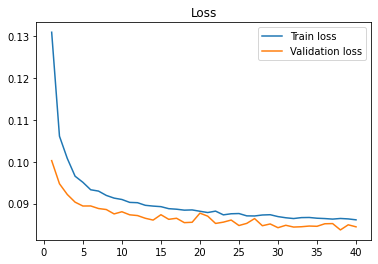

In [175]:

nb_epoch = 40
plt.title('Loss')
plt.plot(range(1,nb_epoch+1) , trainloss, label='Train loss')
plt.plot(range(1,nb_epoch+1) , Validloss, label='Validation loss')
plt.legend()
plt.show()

In [176]:
Y_pred_t,Y_true_t, _ = eval_mlp(train_loader, model )
Y_pred,Y_true, _ = eval_mlp(valid_loader, model )

Y_pred = Y_pred.cpu().detach().numpy()
Y_true = Y_true.cpu().detach().numpy()
Y_true_t = Y_true_t.cpu().detach().numpy()
Y_pred_t = Y_pred_t.cpu().detach().numpy()
Y_pred[Y_pred>=0.5]=1
Y_pred[Y_pred<0.5]=0
Y_pred_t[Y_pred_t>=0.5]=1
Y_pred_t[Y_pred_t<0.5]=0
print('---------------------------------------------------------')
print('Train Score')
print(classification_report(Y_true_t , Y_pred_t))
print('---------------------------------------------------------')
print('Test Score')
print(classification_report(Y_true , Y_pred))

---------------------------------------------------------
Train Score
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97    252469
         1.0       0.98      0.97      0.97    301491

    accuracy                           0.97    553960
   macro avg       0.97      0.97      0.97    553960
weighted avg       0.97      0.97      0.97    553960

---------------------------------------------------------
Test Score
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     27913
         1.0       0.98      0.97      0.97     33639

    accuracy                           0.97     61552
   macro avg       0.97      0.97      0.97     61552
weighted avg       0.97      0.97      0.97     61552



In [177]:

tensor_x_feat = torch.Tensor(test) # transform to torch tensor


dataset = TensorDataset(tensor_x_feat)
test_loader = DataLoader(dataset,batch_size=10000,shuffle = False)

def prediction_mlp(test_loader, mlp_feat ):
  
    mlp_feat.eval()

    with torch.no_grad():
        Y_pred = []

        for idx, batch in enumerate(test_loader):

            x_feat   = batch[0].cuda()


            output_feat = mlp_feat(x_feat)

            Y_pred.append(output_feat.squeeze())
        return torch.hstack(Y_pred)

In [178]:
pred_test = prediction_mlp(test_loader, model )
pred_test[pred_test>=0.5]=1
pred_test[pred_test<0.5]=0
pred_test=pred_test.cpu().detach().numpy()
print(np.sum(pred_test))

17315.0


In [179]:

# write predictions to .csv file suitable for Kaggle (just make sure to add the column names)
predictions = zip(range(len(testing_set)), pred_test)
rows =[]
for row in predictions:
       rows.append(row) 

np.savetxt("file_name.csv", rows, delimiter=",", fmt='%s')

##Roc curve


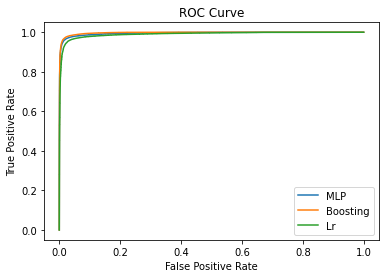

AUC MLP 0.9950132183091173
AUC Boosting 0.9971490472598423
AUC lr 0.9900513640541394


In [180]:

#MLP pred
Y_pred,Y_true, _ = eval_mlp(valid_loader, model )
Y_pred=Y_pred.cpu().detach().numpy()
Y_true=Y_true.cpu().detach().numpy()

fpr_mlp, tpr_mlp, thresholds = roc_curve(Y_true,Y_pred )

fpr_Gradient_boosting, tpr_Gradient_boosting, thresholds = roc_curve(y_val,classifier.predict_proba(X_val)[:,1] )

fpr_Gradient_lr, tpr_Gradient_lr, thresholds = roc_curve(y_val,clf.predict_proba(X_val)[:,1] )


plt.plot(fpr_mlp, tpr_mlp ,label='MLP')
plt.plot(fpr_Gradient_boosting, tpr_Gradient_boosting ,label='Boosting')
plt.plot(fpr_Gradient_lr, tpr_Gradient_lr ,label='Lr')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
print('AUC MLP' , roc_auc_score(Y_true,Y_pred))
print('AUC Boosting' , roc_auc_score(y_val,classifier.predict_proba(X_val)[:,1] ))
print('AUC lr' , roc_auc_score(y_val,clf.predict_proba(X_val)[:,1] ))


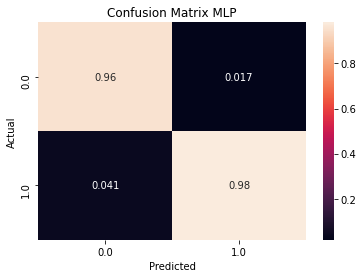

In [181]:
Y_pred[np.where(Y_pred>0.5)]=1
Y_pred[np.where(Y_pred<=0.5)]=0

data = {}
data['y_Actual'] = list(Y_true)
data['y_Predicted'] = list(Y_pred)

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix = confusion_matrix/np.sum(confusion_matrix)
plt.title('Confusion Matrix MLP')
sns.heatmap(confusion_matrix, annot=True)
plt.show()

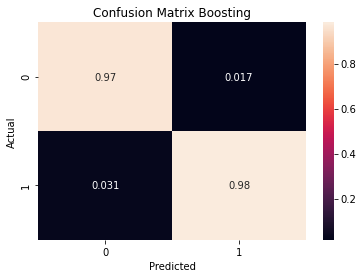

In [182]:
Y_pred = classifier.predict(X_val)

data = {}
data['y_Actual'] = list(y_val)
data['y_Predicted'] = list(Y_pred)

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix = confusion_matrix/np.sum(confusion_matrix)
plt.title('Confusion Matrix Boosting')
sns.heatmap(confusion_matrix, annot=True)
plt.show()